Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


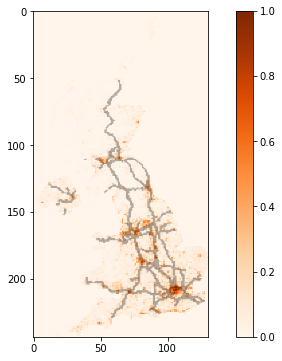

In [3]:
### Modelling the interplay of SARS-CoV-2 variants in the United Kingdom.
### N. L. Barreiro, T. Govezensky, C. I. Ventura, M. Nunez, P. G. Bolcatto, and R. A. Barrio
### code author: Dr. Nadia Barreiro
### UK map code

### COPY ALL THE FILES TO THE SAME FOLDER

## Information extracted from:
## WorldPop. Global high resolution population denominators project. Funded by The Bill Melinda Gates Foundation
## (OPP1134076) Sch. Geogr. Environ. Sci. Univ. Southampton; Dep. Geogr. Geosci. Univ. Louisville; Departement de
## Geogr. Univ. de Namur) Cent. for Int. Earth Sci. Inf. Netw. (CIESIN), Columbia Univ. DOI: https://dx.doi.org/10.5258/
## SOTON/WP00670 (2018) 
## https://hub.worldpop.org/geodata/summary?id=34480

## Routes obtained from https://www.google.com/maps/@53.9474027,-2.9728428,5.62z   (the image was saved, re-scaled, changed to black and white and edited with standard free graphic software to keep only routes)


### IMPORTANT!!!! To use in google colab GC=1, else GC=0.
GC=1
#For GC=0 install geopandas package in your computer


###### Importing libraries ####################

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.lines as mlines
import matplotlib.image as mpimg

###### Tu use it in google drive jupyter notebook - The program will ask authorization in order to open files in drive ############################
if GC==1:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    #!ls "/content/drive/My Drive/" -----------------> uncomment to dir in drive 

    !pip install geopandas
    import geopandas as gpd
elif GC==0:
    import geopandas as gpd     


##########################################################################################################################################

if GC==1:
  path0="/content/drive/My Drive/Colab Notebooks/SEIRV-Variants/"
else:
  path0=""


from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/GBR/gbr_ppp_2020_1km_ASCII_XYZ.zip'
with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(path0)


pop2=pd.read_csv(path0 +'ppp_GBR_2020_1km_Aggregated.csv')
Pop2=gpd.GeoDataFrame(pop2,geometry=gpd.points_from_xy(pop2.X, pop2.Y),crs='EPSG:4326') # recognise coordinates
Pop2['proj']=Pop2['geometry'].to_crs('EPSG:27700') # Projects coordinates in km scale
Pop2=Pop2.drop(['X','Y'],axis=1)
Pop2['geometry']=Pop2['proj']
Pop2['pop']=Pop2['Z']
pop1=Pop2.drop(['Z'], axis=1)
pop1=Pop2.drop(['proj'], axis=1)

def separador1(x):
    y=str(x)
    [point,lon,lat]=y.split(" ")
    lat=float(lat.replace(')',''))/1000
    return lat

def separador2(x):
    y=str(x)
    [point,lon,lat]=y.split(" ")
    lon=float(lon.replace('(',''))/1000
    return lon

pop1['x']=pop1['geometry'].apply(separador2)
pop1['y']=pop1['geometry'].apply(separador1)

minimo_x_a_escala=pop1['x'].min()
minimo_y_a_escala=pop1['y'].min()

pop1['x']=pop1['x']-minimo_x_a_escala # scale change X
pop1['y']=pop1['y']-minimo_y_a_escala # scale change y

pop1=pop1.drop('geometry',axis=1)
pop1.to_csv(path0 +'pop_UK_Km.csv') 


pop1=pd.read_csv(path0 +'pop_UK_Km.csv')
pop1=pop1.drop('Unnamed: 0' ,axis=1)

max_x=pop1['x'].max()
max_y=pop1['y'].max()

K=5 #lateral dimension of the squares in the grid

P=int(round(max_x/K +0.49,0)) 
Q=int(round(max_y/K +0.49,0)) 

pop3=np.zeros((Q,P)) 

for i in range(P):
    for j in range(Q):
        mask=(pop1['x']>=i*K) & (pop1['x']<K+i*K) & (pop1['y']>=j*K) & (pop1['y']<j*K+K)
        aux= pop1[mask]['pop'].sum()
        pop3[Q-j-1,i]= aux


pop4=np.round(pop3)

pop4[pop4==1]=0

path1 = path0 +"pop_uk_131_243.csv"
np.savetxt(path1, pop4, delimiter=",")

path3=path0 +"rutas UK5.jpg"
img = mpimg.imread(path3)  
def rgb2gray(rgb): 
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 1-(0.2989 * r + 0.5870 * g + 0.1140 * b)/254.9745-1.110223e-16
    return gray
gris = rgb2gray(img) 
gris=np.array(gris)
gris[gris<0.1]=0
gris[gris>=0.1]=1

path2 = path0 +"mob_131_243_UK.csv"
np.savetxt(path2,gris,delimiter=",")

r01=np.loadtxt(path1,delimiter=',') 
nut1=np.loadtxt(path2,delimiter=',') 

maxro=np.max(r01)
ro=np.copy(r01)/maxro # normalized density
 
rcm = cm.get_cmap('Oranges')
fig = plt.figure(figsize=(10,6))
sub1 = plt.subplot(1, 1, 1)
alphas =nut1*0.3
psm = sub1.imshow(np.sqrt(ro), cmap=rcm, vmin=0, vmax=1, interpolation='nearest')
sub1.imshow(nut1,cmap="Greys",alpha=alphas)
   # sub1.set_xticks([])
   # sub1.set_yticks([])
fig.colorbar(psm, ax=sub1)
plt.show()


    